*A general note on this notebook* - while the analysis for this study of iPTF 16abc is being conducted in an open fashion, we have not obtained permission to share the data of other researchers.

If you are hoping to run this analysis locally, you will need to adjust the absolute paths to the velocity data read in below. These data are from [Blondin et al. 2012](http://adsabs.harvard.edu/abs/2012AJ....143..126B), and I suspect that Stephane Blondin will happily share them with you.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib.ticker import MultipleLocator

# import matplotlib as mpl
# from matplotlib.ticker import MultipleLocator
# mpl.rc('text', usetex = True)
# mpl.rc('font', family='serif')


%matplotlib notebook

In [4]:
data_dir = "/Users/adamamiller/astronomy/SN_Ia_models/ObsData/Blondin2012/"
ss_dat = pd.read_csv(data_dir + "vabsSiII6355_SS.csv")
cl_dat = pd.read_csv(data_dir + "vabsSiII6355_CL.csv")
cn_dat = pd.read_csv(data_dir + "vabsSiII6355_CN.csv")
bl_dat = pd.read_csv(data_dir + "vabsSiII6355_BL.csv")

In [5]:
ss_sne = ss_dat['SN'].unique()
cl_sne = cl_dat['SN'].unique()
cn_sne = cn_dat['SN'].unique()
bl_sne = bl_dat['SN'].unique()

<IPython.core.display.Javascript object>


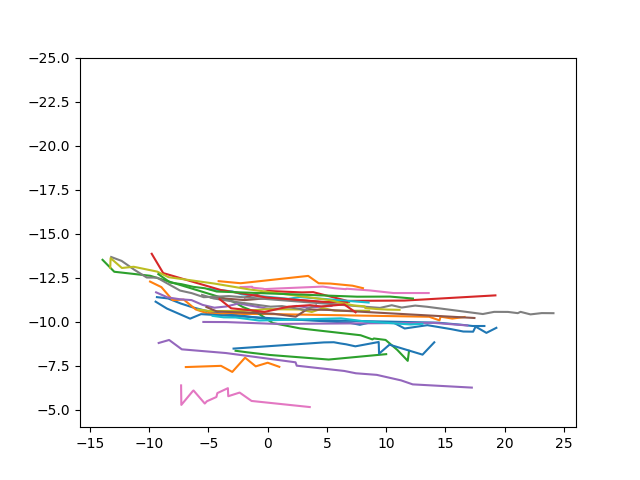

<IPython.core.display.Javascript object>


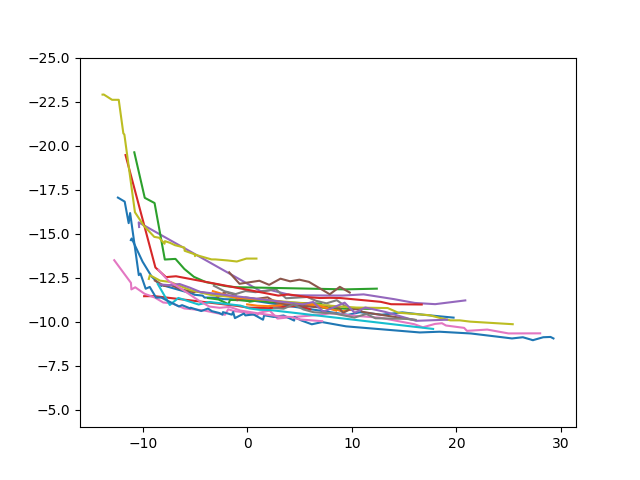

<IPython.core.display.Javascript object>


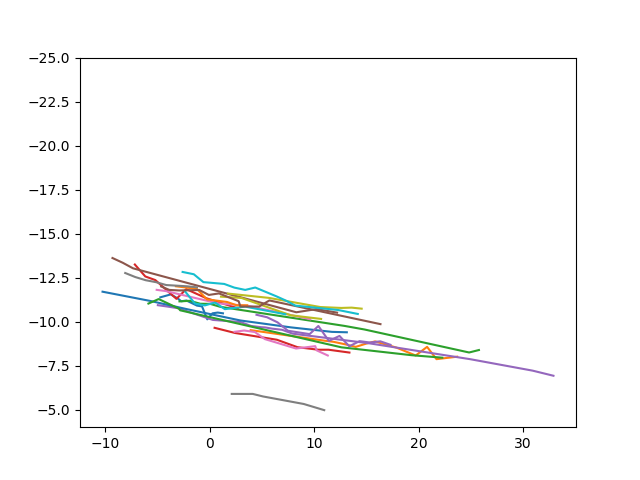

<IPython.core.display.Javascript object>


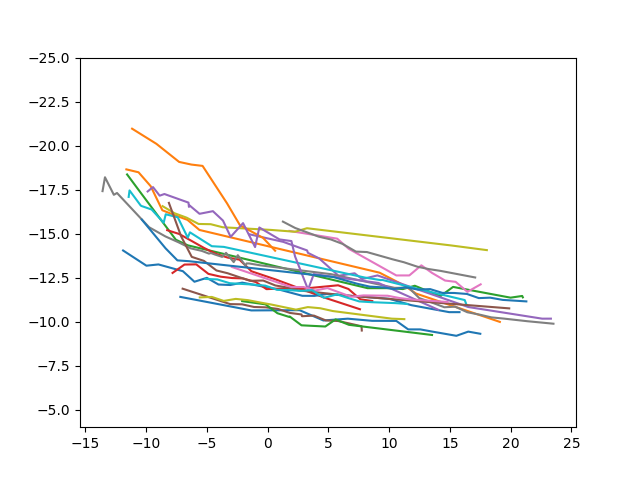

In [6]:
plt.figure()
for ss_sn in ss_sne:
    plt.plot(ss_dat["age"].where(ss_dat["SN"] == ss_sn), ss_dat["vabs"].where(ss_dat["SN"] == ss_sn))
    plt.ylim(-4,-25)
plt.figure()
for cn_sn in cn_sne:
    plt.plot(cn_dat["age"].where(cn_dat["SN"] == cn_sn), cn_dat["vabs"].where(cn_dat["SN"] == cn_sn))
    plt.ylim(-4,-25)
plt.figure()
for cl_sn in cl_sne:
    plt.plot(cl_dat["age"].where(cl_dat["SN"] == cl_sn), cl_dat["vabs"].where(cl_dat["SN"] == cl_sn))
    plt.ylim(-4,-25)
plt.figure()
for bl_sn in bl_sne:
    plt.plot(bl_dat["age"].where(bl_dat["SN"] == bl_sn), bl_dat["vabs"].where(bl_dat["SN"] == bl_sn))
    plt.ylim(-4,-25)

In [7]:
t_grid = np.linspace(-20,40,61)
ss_vel = np.ma.empty((len(ss_sne), len(t_grid)))

In [8]:
for i_sn, ss_sn in enumerate(ss_sne):
    this_sn = np.where(ss_dat["SN"] == ss_sn)
    t_sn = ss_dat["age"].ix[this_sn]
    v_sn = ss_dat["vabs"].ix[this_sn]
    v_interp = np.interp(t_grid, t_sn, v_sn)
    ss_vel[i_sn] = v_interp
    ss_vel[i_sn] = np.ma.masked_where((t_grid < min(t_sn)) | (t_grid > max(t_sn)), ss_vel[i_sn])

<IPython.core.display.Javascript object>


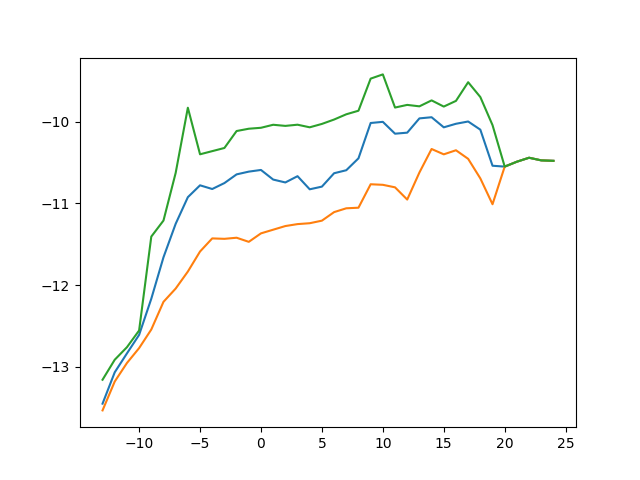

/Users/adamamiller/miniconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1043: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)


In [9]:
plt.figure()
plt.plot(t_grid, np.ma.median(ss_vel, axis = 0))
plt.plot(t_grid, np.nanpercentile(np.ma.filled(ss_vel, np.nan), 25, axis = 0))
plt.plot(t_grid, np.nanpercentile(np.ma.filled(ss_vel, np.nan), 75, axis = 0))

<IPython.core.display.Javascript object>


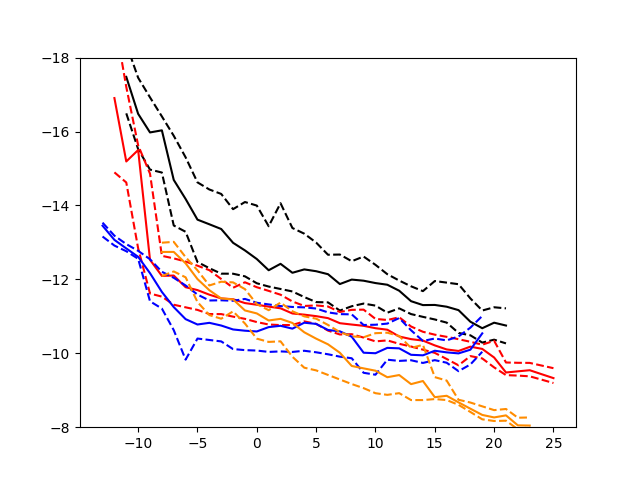

/Users/adamamiller/miniconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1043: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)


(-8, -18)

In [10]:
plt.figure()
t_grid = np.linspace(-20,40,61)
for branch_class, line_col in zip([bl_dat, cn_dat, ss_dat, cl_dat], ["k","r","b","DarkOrange"]):
    sne = branch_class['SN'].unique()
    vel_arr = np.ma.empty((len(sne), len(t_grid)))
    for i_sn, sn in enumerate(sne):
        this_sn = np.where(branch_class["SN"] == sn)
        t_sn = branch_class["age"].ix[this_sn]
        v_sn = branch_class["vabs"].ix[this_sn]
        v_interp = np.interp(t_grid, t_sn, v_sn)
        vel_arr[i_sn] = v_interp
        vel_arr[i_sn] = np.ma.masked_where((t_grid < min(t_sn)) | (t_grid > max(t_sn)), vel_arr[i_sn])
    min_3_vels = np.where(np.ma.masked_array.count(vel_arr, axis = 0) >= 3)
    plt.plot(t_grid[min_3_vels], np.ma.median(vel_arr, axis = 0)[min_3_vels], color = line_col)
#     plt.plot(t_grid, np.nanpercentile(np.ma.filled(vel_arr, np.nan), 50, axis = 0), 
#              '-', color = line_col)
    plt.plot(t_grid[min_3_vels], np.nanpercentile(np.ma.filled(vel_arr, np.nan), 25, axis = 0)[min_3_vels], 
             '--', color = line_col)
    plt.plot(t_grid[min_3_vels], np.nanpercentile(np.ma.filled(vel_arr, np.nan), 75, axis = 0)[min_3_vels], 
             '--', color = line_col)
plt.ylim(-8, -18)

## Measuring the Si II velocity of 16abc

The approach here will be to measure the minimum of absorption. I will do that following the convolution of the spectrum with a FWHM = 2000 km/s gaussian kernel.

**Update** - the gaussian method of fitting for the velocity works better - those results (from `./SpectralLineAnalysis.ipynb` will be read in and used instead of the minimum measurement method described below)

In [117]:
import tables

class Spectroscopy(object):
    
    def __init__(self, MJD, telescope, instrument, data):
        self.MJD = MJD
        self.telescope = telescope
        self.instrument = instrument
        self.data = data
        idx = np.logical_and(self.data["wavelength"] > 6000,
                             self.data["wavelength"] < 7000)
        self.data["flux"] /= np.median(self.data["flux"][idx])
        
    def __gt__(self, other):
        return self.MJD > other.MJD
    
    def __lt__(self, other):
        return self.MJD < other.MJD
    
    def __eq__(self, other):
        return self.MJD == other.MJD
    
    def __ge__(self, other):
        return self > other or self == other
    
    def __le__(self, other):
        return self < other or self == other
    
    def plot(self, ax, offset=0, **keywords):
        ax.plot(self.data["wavelength"], 
                self.data["flux"] + offset, 
                **keywords)

# load light curve data
h5file = tables.open_file("iPTF16abc.h5", mode="r")
table_group = h5file.root.spectroscopy

spectra = list()
for table in table_group:
    spec = np.array([(row["wavelength"], row["flux_lambda"])
                     for row in table],
                    dtype=[("wavelength", "f"), ("flux", "f")])
    
    spectra.append(Spectroscopy(table.attrs.OBS_DATE, 
                                table.attrs.TELESCOPE,
                                table.attrs.INSTRUMENT,
                                spec))
spectra.sort()

<IPython.core.display.Javascript object>


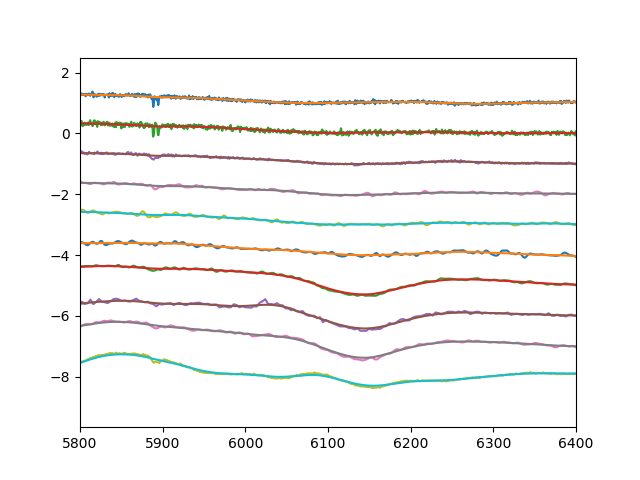

(5800, 6400)

In [175]:
from constantVelocityKernel.specconvolve import convolve_with_constant_velocity_kernel
from astropy.constants import c

z_16abc = 0.0234
T_MAX = 57499.537694
kern_vel_fwhm = 2e3 # kernel velocity FWHM in km/s

Nspec = 10
vSiII = np.empty(Nspec)
phase_arr = np.empty(Nspec)
vel_idx = 0
plt.figure()
for spec in spectra:    
    if spec.telescope in ["VLT"]:
        continue
    phase = (spec.MJD - T_MAX)/(1+z_16abc)
    if phase > -15 and phase < 20:
        wave = spec.data['wavelength']/(1+z_16abc)
        flux = spec.data['flux']
        opt_region = np.where((wave >= 3600) & (wave < 10000))
        
        interp_grid, var_kern_flux = convolve_with_constant_velocity_kernel(wave[opt_region], flux[opt_region], kern_vel_fwhm)
        plt.plot(wave, flux - vel_idx)
        plt.plot(interp_grid, var_kern_flux - vel_idx)
        
        if phase < 0:
            SiII_region = np.where( (interp_grid > 6000) & (interp_grid < 6150) )
        else:
            SiII_region = np.where( (interp_grid > 6000) & (interp_grid < 6200) )


        SiII_lambdaAtMin = interp_grid[SiII_region][np.argmin(var_kern_flux[SiII_region])]
        SiII_velAtMin = (SiII_lambdaAtMin - 6355)/6355*c.value*1e-6

        vSiII[vel_idx] = SiII_velAtMin
        phase_arr[vel_idx] = phase       
        
        vel_idx += 1
plt.xlim(5800, 6400)
# plt.ylim(0.5, 2)


<IPython.core.display.Javascript object>


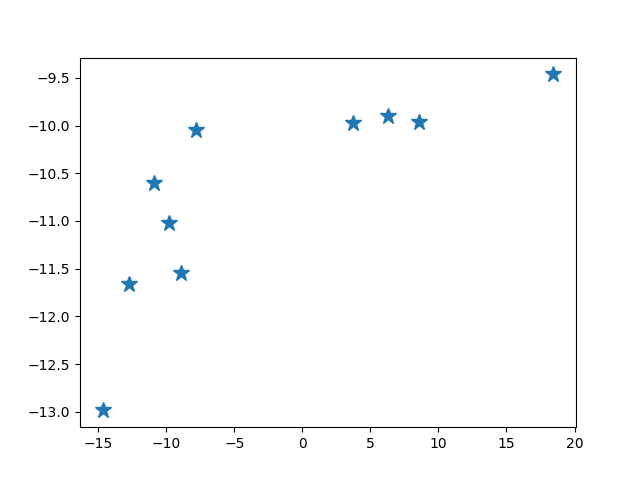

In [178]:
plt.figure()
plt.plot(phase_arr, vSiII, '*', ms = 12)

In [2]:
phase_arr, vSiII, vSiII_unc = np.loadtxt("SiII_velocities.dat", unpack =True)

<IPython.core.display.Javascript object>


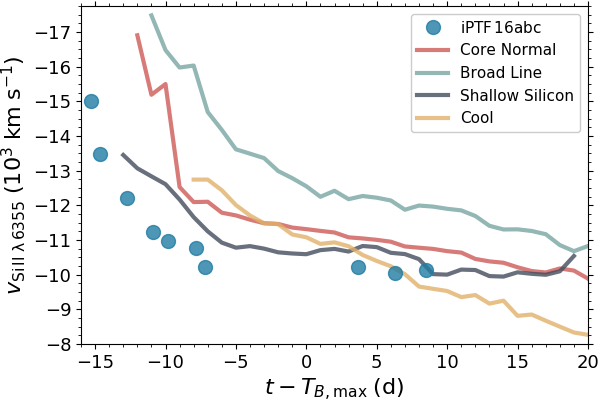

In [18]:
aam_colors = {'mustard': "#E29930",
             'blue': "#217CA3",
             'asphalt': "#32384D",
             'navy': "#444C5C",
             'punch': "#CE5A57",
             'ocean': "#78A5A3",
             'warm': "#E1B16A",}

fig, ax = plt.subplots(figsize=(6,4))

# plot 16abc
ax.plot(phase_arr, vSiII*-1, 'o', 
        color = aam_colors["blue"], ms = 10, alpha = 0.8, zorder = 100,
        label = r"$\mathrm{iPTF\,16abc}$")

t_grid = np.linspace(-20,40,61)
for branch_class, line_col, line_label in zip([cn_dat, bl_dat, ss_dat, cl_dat], 
                                              ["punch","ocean","navy","warm"],
                                              ["Core Normal", "Broad Line", 
                                               "Shallow Silicon", "Cool"]):
    sne = branch_class['SN'].unique()
    vel_arr = np.ma.empty((len(sne), len(t_grid)))
    for i_sn, sn in enumerate(sne):
        this_sn = np.where(branch_class["SN"] == sn)
        t_sn = branch_class["age"].ix[this_sn]
        v_sn = branch_class["vabs"].ix[this_sn]
        v_interp = np.interp(t_grid, t_sn, v_sn)
        vel_arr[i_sn] = v_interp
        vel_arr[i_sn] = np.ma.masked_where((t_grid < min(t_sn)) | (t_grid > max(t_sn)), vel_arr[i_sn])

    min_3_vels = np.where(np.ma.masked_array.count(vel_arr, axis = 0) >= 3)
    ax.plot(t_grid[min_3_vels], np.ma.median(vel_arr, axis = 0)[min_3_vels], 
            color = aam_colors[line_col], alpha = 0.8, lw = 3,
            label = line_label)

ax.set_ylim(-8, -17.75)
ax.set_xlim(-16, 20)
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.25))
ax.set_ylabel(r"$v_\mathrm{Si\,II\;\lambda\,6355} \; (10^3 \;\mathrm{km\;s}^{-1})$", fontsize=16)
ax.set_xlabel(r"$t - T_{B,\mathrm{max}} \; (\mathrm{d})$", fontsize=16)
ax.tick_params(axis='both', which='both', top = True, right = True, labelsize=13)
ax.legend(loc='upper right', framealpha = 1, fontsize = 11)
fig.subplots_adjust(top = 0.985, bottom = 0.14, left = 0.135, right = 0.98)

# plt.savefig("Branch_vel_evol.pdf")

In [13]:
vSiII

array([ 14.99843207,  13.46801874,  12.21308847,  11.21685723,
        10.9787868 ,  10.78195498,  10.20823783,  10.21815429,
        10.04901882,  10.12236009])